<a href="https://colab.research.google.com/github/RDelg/rl-2048/blob/master/2048.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import random
from collections import deque

import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tqdm.notebook import tqdm

In [0]:
GAMMA = 0.95
LEARNING_RATE = 0.001

MEMORY_SIZE = 1000000
BATCH_SIZE = 20

EXPLORATION_MAX = 1.0
EXPLORATION_MIN = 0.01
EXPLORATION_DECAY = 0.995

In [0]:
class Game2048(object):
    def __init__(self, n, dims):
        assert n > 3, "n must be greater than 3"
        assert dims > 1, "dims must be greater than 1"
        self.n = n
        self.dims = dims
        self.n_news = ((n**self.dims)//2**4)*2
        self.shape = [n for i in range(self.dims)]
        self.actions = [(dim, 0) for dim in range(self.dims)] + [(dim, 1) for dim in range(self.dims)]
        self.reset()
    
    def reset(self):
        self.board = np.zeros(shape=self.shape)
        self.next_board = np.zeros(shape=self.shape)
        self.score = 0
        self.add_numbers()
        return self.board
    
    def add_numbers(self):
        idx_zero = np.argwhere((self.board == 0))
        if idx_zero.shape[0] > self.n_news:
            insert_idx = idx_zero[np.argsort(np.random.uniform(size=idx_zero.shape[0]))[:self.n_news], :]
        elif idx_zero.shape[0] > 0 and idx_zero.shape[0] <= self.n_news:
            insert_idx = idx_zero
        else:
            return 1
        np.put(self.board, np.ravel_multi_index(insert_idx.T, self.shape), 2, mode='raise')
        return 0
    
    def step(self, action_n):
        assert action_n < self.dims * 2, 'invalid action number'
        score = self.score
        action = self.actions[action_n]
        self.next_board = np.copy(self.board)
        if action[1]:
            it_list = zip(range(self.n-1, 0, -1), range(self.n-2, -1, -1))
        else:
            it_list = zip(range(self.n-1), range(1,self.n))
        for i, next_i in it_list:
            index_base = np.ones(shape=[1 for x in range(self.dims)], dtype=np.int8)
            xi = np.take_along_axis(self.next_board, index_base*i, axis=action[0])
            xiplus = np.take_along_axis(self.next_board, index_base*next_i, axis=action[0])
            with np.nditer([xi, xiplus], flags=[], op_flags=[['readwrite'], ['readwrite']]) as it:
                for j, next_j in it:
                    if j[...] != 0 and next_j[...] == 0:
                        next_j[...] = j[...]
                        j[...] = 0
                    elif j[...] == next_j[...]:
                        next_j *= 2
                        j[...] = 0
                        score += next_j[...]
            np.put_along_axis(self.next_board, index_base*i, xi, axis=action[0])
            np.put_along_axis(self.next_board, index_base*next_i, xiplus, axis=action[0])
        self.board = self.next_board
        diff_score = score - self.score
        self.score = score
        is_final = self.add_numbers()
        if is_final:
            return self.board, self.score, is_final
        else:
            return self.board, diff_score, is_final
    
    def show(self, video=None):       
        n = self.n
        block_size = 50
        
        img = (self.board * (np.iinfo(np.uint8).max/np.max(self.board))).astype(np.uint8)
        img = Image.fromarray(img, "L")
        img_reshaped = img.resize((n * block_size, n * block_size), resample=Image.BOX)
        img_reshaped = np.float32(img_reshaped)
        text_color = (200, 20, 220)
        for i in range(n):
            for j in range(n):
                block_value = str(int(self.board[i, j]))
                cv2.putText(
                    img_reshaped,
                    block_value,
                    (j*block_size+int(block_size / 2)-10*len(block_value), i*block_size+int(block_size/2)+10),
                    fontFace=cv2.FONT_HERSHEY_DUPLEX,
                    fontScale=1,
                    color=text_color
                )
        if video is not None:
            video.write(np.uint8(img_reshaped))
        else:
            from google.colab.patches import cv2_imshow
            cv2_imshow(img_reshaped)

In [0]:
class DQNSolver(object):

    def __init__(self, observation_space, action_space):
        self.exploration_rate = EXPLORATION_MAX

        self.action_space = action_space
        self.memory = deque(maxlen=MEMORY_SIZE)

        self.model = Sequential()
        self.model.add(Dense(24, input_shape=(observation_space,), activation="relu"))
        self.model.add(Dense(24, activation="relu"))
        self.model.add(Dense(self.action_space, activation="linear"))
        self.model.compile(loss="mse", optimizer=Adam(lr=LEARNING_RATE))

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.exploration_rate:
            return random.randrange(self.action_space)
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])

    def experience_replay(self):
        if len(self.memory) < BATCH_SIZE:
            return
        batch = random.sample(self.memory, BATCH_SIZE)
        for state, action, reward, state_next, terminal in batch:
            q_update = reward
            if not terminal:
                q_update = (reward + GAMMA * np.amax(self.model.predict(state_next)[0]))
            q_values = self.model.predict(state)
            q_values[0][action] = q_update
            self.model.fit(state, q_values, verbose=0)
        self.exploration_rate *= EXPLORATION_DECAY
        self.exploration_rate = max(EXPLORATION_MIN, self.exploration_rate)
    
    def save(self, path):
        self.model.save(path)
    
    def load(self, path):
        self.model = tf.keras.models.load_model(path)

In [0]:
def play_random(n, dims, show=False):
    game = Game2048(n=n, dims=dims)
    if dims == 2 and show:
        video = cv2.VideoWriter(f'random_n_{n}_dims_{dims}.mp4', cv2.VideoWriter_fourcc(*"DIVX"), 5., (200, 200), 0)
    is_final = False
    while not is_final:
        action_n = int(np.random.uniform()*len(game.actions))
        new_board, score, is_final =  game.step(action_n=action_n)
        if dims == 2 and show:
            game.show(video=video)
    if dims == 2 and show:
        video.release()
        game.show()
    return game.board, score

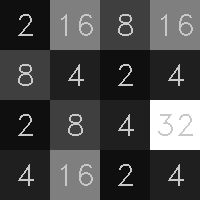

[[ 2. 16.  8. 16.]
 [ 8.  4.  2.  4.]
 [ 2.  8.  4. 32.]
 [ 4. 16.  2.  4.]] 340.0


In [6]:
board, score = play_random(n=4, dims=2, show=True);
print(board, score)

In [7]:
board, score = play_random(n=4, dims=3);
print(board, score)

[[[ 2. 32.  8. 16.]
  [32. 16.  2.  4.]
  [ 2.  4.  2.  4.]
  [ 2.  4.  2. 16.]]

 [[16.  2.  4.  2.]
  [ 2. 32.  8. 16.]
  [ 8.  2.  8. 16.]
  [16.  2.  4.  8.]]

 [[64.  4. 64.  8.]
  [ 4.  2. 16. 32.]
  [ 2. 16.  4.  2.]
  [ 2.  4.  8.  2.]]

 [[ 8.  2.  8. 16.]
  [32.  8.  4.  2.]
  [ 8.  4.  8.  4.]
  [ 4.  8.  2.  4.]]] 2028.0


In [8]:
board, score = play_random(n=4, dims=5);
print(score)

113904.0


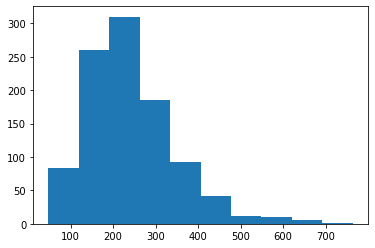

In [9]:
iterations = 1000
scores = np.zeros(shape=(iterations))
for i in tqdm(range(iterations)):
    _, scores[i] = play_random(4, 2)

import matplotlib.pyplot as plt
plt.hist(scores);

In [10]:
env = Game2048(n=4, dims=2)
observation_space = env.board.ravel().shape[0]
action_space = len(env.actions)
dqn_solver = DQNSolver(observation_space, action_space)
run = 0
best_step = 0
for _ in tqdm(range(15)):
    run += 1
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    step = 0
    while True:
        step += 1
        action = dqn_solver.act(state)
        state_next, reward, terminal = env.step(action)
        reward = reward if not terminal else -reward
        state_next = np.reshape(state_next, [1, observation_space])
        dqn_solver.remember(state, action, reward, state_next, terminal)
        dqn_solver.experience_replay()
        state = state_next
        if terminal:
            if step > best_step:
                best_step = step
                dqn_solver.save('best_model.h5')
            print("Run: " + str(run) + ", exploration: " + str(dqn_solver.exploration_rate) + ", score: " + str(step))
            break

Run: 1, exploration: 0.995, score: 20
Run: 2, exploration: 0.8866535105013078, score: 23
Run: 3, exploration: 0.7822236754458713, score: 25
Run: 4, exploration: 0.6866430931872001, score: 26
Run: 5, exploration: 0.5997278763867329, score: 27
Run: 6, exploration: 0.5134164023722473, score: 31
Run: 7, exploration: 0.43952667968844233, score: 31
Run: 8, exploration: 0.34901730169741024, score: 46
Run: 9, exploration: 0.3173112652388396, score: 19
Run: 10, exploration: 0.27714603575484437, score: 27
Run: 11, exploration: 0.24328132378095624, score: 26
Run: 12, exploration: 0.21570623976979014, score: 24
Run: 13, exploration: 0.1846622876013121, score: 31
Run: 14, exploration: 0.15967890763313974, score: 29
Run: 15, exploration: 0.1313250884614265, score: 39



In [0]:
def play_ai(n, dims, model_path, show=False):
    env = Game2048(n=n, dims=dims)
    observation_space = env.board.ravel().shape[0]
    action_space = len(env.actions)
    model = DQNSolver(observation_space, action_space)
    model.load(model_path)
    state = env.reset()
    state = np.reshape(state, [1, observation_space])
    if dims == 2 and show:
        video = cv2.VideoWriter(f'ai_n_{n}_dims_{dims}.mp4', cv2.VideoWriter_fourcc(*"DIVX"), 5., (200, 200), 0)
    is_final = False
    while not is_final:
        action_n =  dqn_solver.act(state)
        state, score, is_final =  env.step(action_n=action_n)
        state = np.reshape(state, [1, observation_space])
        if dims == 2 and show:
            env.show(video=video)
    if dims == 2 and show:
        video.release()
        env.show()
    return env.board, score

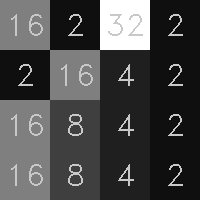

(array([[16.,  2., 32.,  2.],
        [ 2., 16.,  4.,  2.],
        [16.,  8.,  4.,  2.],
        [16.,  8.,  4.,  2.]]), 364.0)

In [12]:
play_ai(4,2,'best_model.h5',show=True)